In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
import torchvision.models as models
from skimage import io, transform
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi']= 300

<h3> Create Dataset Class. </h3>
Refer :<p>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html<p>
https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel<p>
https://github.com/Miffyli/im2latex-dataset<p>
    
Add transformations to loaded image

In [2]:
class Dataset(data.Dataset):
    def __init__(self,data_filename, formula_filename, transform =None):
        self.data_filename = data_filename
        self.formula_filename = formula_filename
        self.files = open(self.data_filename,'r').readlines()
        self.formulas = open(self.formula_filename,'r').readlines()
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        line_num, img_file = self.files[index].strip().split()[0:2]
        img_file += ".png"
        img_path = os.path.join('formula_images/', img_file)
        #image = io.imread(img_path)
        image = Image.open(img_path)
        image = Image.Image.crop(image,box=[200,0,1500,1300])
        formula = self.formulas[int(line_num)]
        if self.transform:
            image = self.transform(image)
        return image, formula

In [3]:
dataset_train = Dataset('im2latex_train.lst','im2latex_formulas.lst')

ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .\label{eq:sps1}



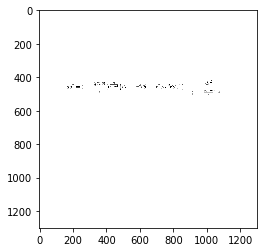

In [4]:
img , label = dataset_train[0]
print label
plt.imshow(img)
plt.show()

Define image transformations

In [21]:
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                ])
dataset_train = Dataset('im2latex_train.lst','im2latex_formulas.lst',transform=transform)



In [22]:
vgg19 = models.vgg19(pretrained=True)

In [23]:
train_dl = data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
inputs , labels = next(iter(train_dl))
inputs = Variable(inputs)

/home/shubham/anaconda2/lib/python2.7/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shubham/anaconda2/lib/python2.7/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shubham/anaconda2/lib/python2.7/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shubham/anaconda2/lib/python2.7/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [12]:
vgg1 = vgg19.features

In [13]:
out = vgg1(inputs)

In [31]:
vgg1.state_dict()['0.weight'].shape

torch.Size([64, 3, 3, 3])

In [58]:
model = models.resnet50(pretrained="true")

In [59]:
model = nn.Sequential(*list(model.children())[:-5])
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [60]:
out=model(inputs)

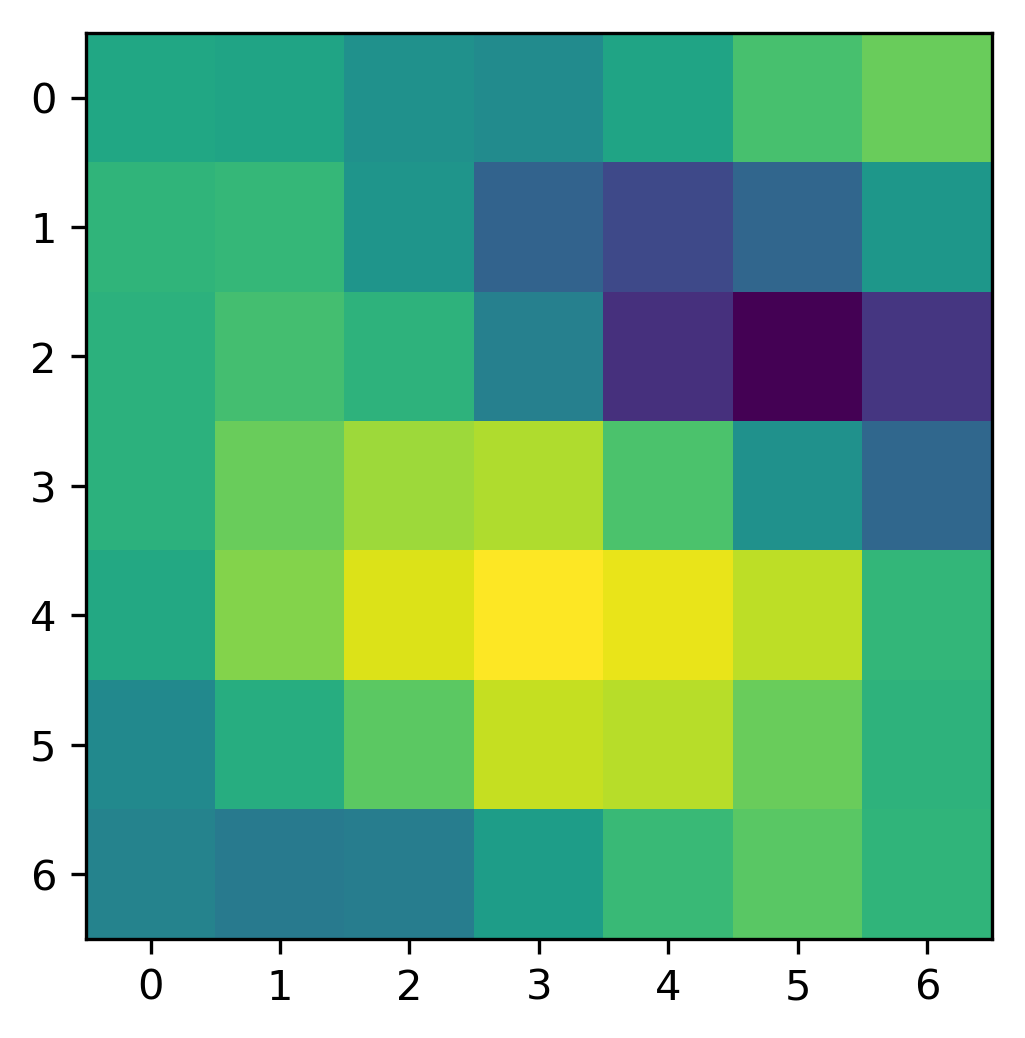

In [61]:
plt.imshow(model.state_dict()['0.weight'][30,1].numpy())

In [50]:
class modelBottom(nn.Module):
    def __init__(self, original_model, layers):
        super(modelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children())[:layers])
        
    def forward(self, x):
        x = self.features(x)
        return x

In [51]:
model = modelBottom(vgg19,5)

In [52]:
model

modelBottom(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [62]:
out=model(inputs)

In [63]:
out.shape

torch.Size([4, 256, 56, 56])

In [64]:
def plotImg(channel,num):
    plt.imshow(out[channel,num].detach().numpy(),cmap="gray")

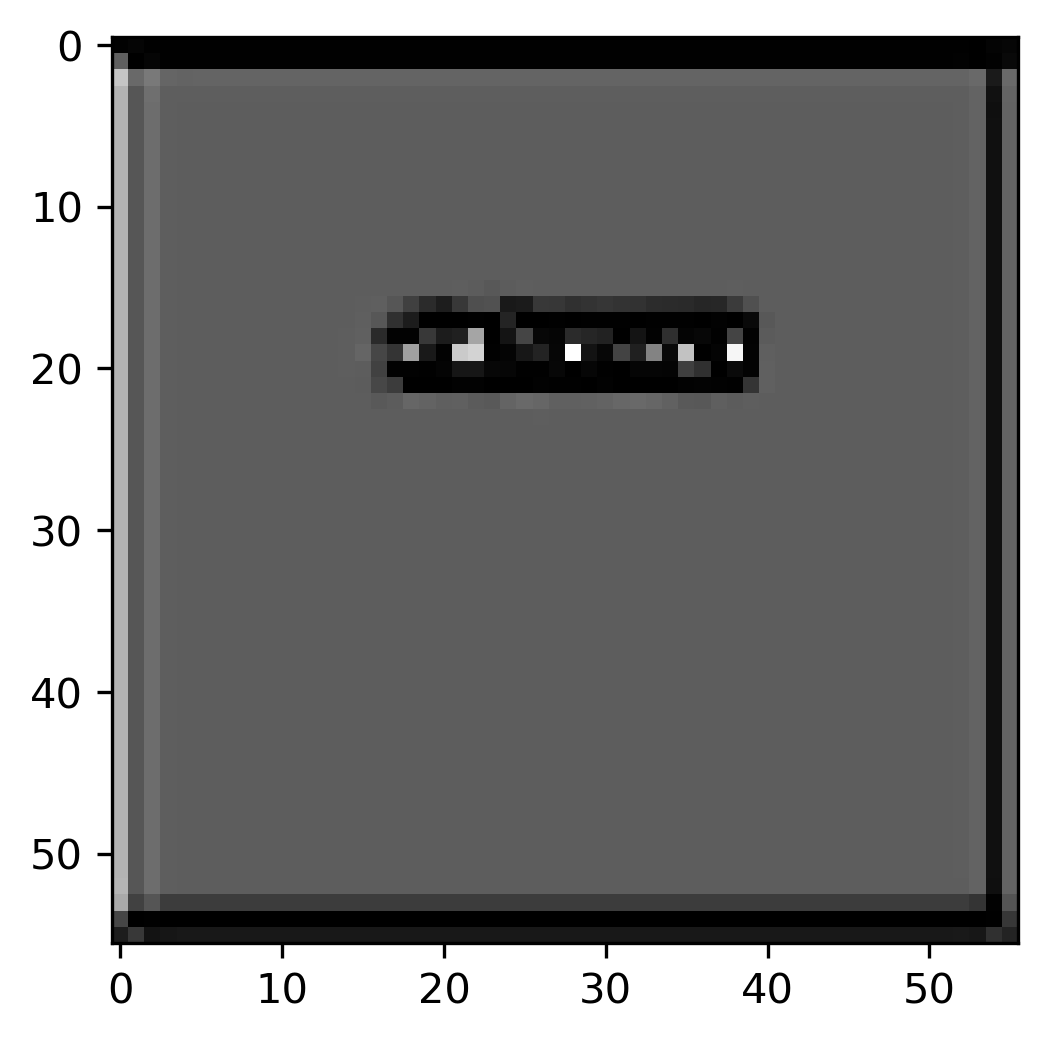

In [66]:
plotImg(3,250)